# Data Preparation

### Import packages

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
from sklearn import preprocessing
from datetime import datetime

### Import utilities

In [2]:
import sys
sys.path.append('../src/')
import utils

# map to rename disease categories
disease_cat_map  = utils.disease_rename_map 

### Import data

In [5]:
# connect to database
conn = sqlite3.connect("../data/db/gfm.db")

In [6]:
# read list of tables in database
list_all_tables = "SELECT name FROM sqlite_master WHERE type='table';"

# print out list of tables to make sure db connection is working
pd.read_sql_query(list_all_tables, conn)

,name
0,scrape_tb
1,feed_tb
2,donation_tb
3,team_member_tb
4,comment_tb
5,update_tb
6,int_pivot
7,primary_cat
8,disease_pivot
9,master


In [7]:
# import master data
master = pd.read_sql_query("SELECT * FROM master", conn)

In [8]:
# import entity recognition data
er = pd.read_sql_query("SELECT * FROM er_final", conn)

In [9]:
# import disease category data as pivoted table
disease_pivot = pd.read_sql_query("SELECT * FROM pivot", conn)

In [10]:
# import data on "primary" disease cateogry
primary_cat = pd.read_sql_query("SELECT * FROM primary_disease",conn)

In [11]:
# # import rest of tables from database

# # web scraping performance data
# scrape_tb = pd.read_sql_query("SELECT * FROM scrape_tb", conn)

# # GFM feed data
# feed_tb = pd.read_sql_query("SELECT * FROM feed_tb", conn)

# # donation data
# donation_tb = pd.read_sql_query("SELECT * FROM donation_tb", conn)

# # team member data
# team_member_tb = pd.read_sql_query("SELECT * FROM team_member_tb", conn)

# # comment data
# comment_tb = pd.read_sql_query("SELECT * FROM comment_tb", conn)

# # update data
# update_tb = pd.read_sql_query("SELECT * FROM update_tb", conn)

# # "intermediate" disease category data as pivoted table
# int_pivot = pd.read_sql_query("SELECT * FROM int_pivot", conn)

# # disease category data as pivoted table
# pivot = pd.read_sql_query("SELECT * FROM pivot", conn)

# # "primary" disease category data
# primary_disease = pd.read_sql_query("SELECT * FROM primary_disease", conn)

In [12]:
# print current column names for master data
[x for x in master.columns]

['index',
 'url',
 'donation_count',
 'donor_reached_max',
 'currencycode',
 'current_amount',
 'goal_amount',
 'fund_name',
 'created_at',
 'social_share_last_update',
 'city',
 'country',
 'postal_code',
 'is_team',
 'year',
 'month',
 'zip_len',
 'zip',
 'state_county_fips',
 'tot_ratio',
 'county_name',
 'ndi_quantile',
 'standardized_ndi',
 'total_population',
 'percent_female',
 'unemployment_rate',
 'median_income',
 'percent_poverty',
 'no_health_insurance',
 'public_health_insurance',
 'private_health_insurance',
 'home_owners',
 'percent_1_1.5_per_room',
 'more_1.5_per_room',
 'renter_occupied',
 'no_car',
 'single_mom',
 'single_dad',
 'home_median_value',
 'ed_percent_highschool',
 'ed_percent_bachelors',
 'has_internet',
 'percent_less_10k',
 'percent_10k_15k',
 'percent_15k_25k',
 'percent_25k_35k',
 'percent_white',
 'percent_under_5',
 'percent_5_to_9',
 'percent_10_to_14',
 'percent_15_to_19',
 'percent_20_to_24',
 'percent_25_to_34',
 'percent_35_to_44',
 'percent_45_

In [14]:
# check number of unique urls (campaigns) with a disease category recognized by entity recognition model
er['url'].nunique()

74016

Additional geographic data

In [15]:
state_pop = pd.read_csv('../data/census/state_pop.csv')

In [16]:
census_regions = pd.read_csv('../data/census/census_regions.csv')

Donation data

In [17]:
donations = pd.read_sql_query("SELECT * FROM donation_tb", conn)

In [18]:
# OOP cost data
# oop = pd.read_excel('../data/jama_oop_data.xlsx', sheet_name = 'GBD OOP')
# gbd_map = pd.read_excel('../data/jama_oop_data.xlsx', sheet_name = 'GBD to CF map')

### Clean data

Primary disease category

In [19]:
del primary_cat['index']

In [20]:
primary_cat.columns = ['url','primary_disease_cat']

In [21]:
primary_disease_dummy = pd.get_dummies(primary_cat['primary_disease_cat'])
cols = primary_disease_dummy.columns.str.lower().str.replace(' ','_').str.replace(',','')
cols = ['pd_' + x for x in cols]
primary_disease_dummy.columns = cols
primary_disease_dummy['url'] = primary_cat['url']

Disease category, not mutually exclusive

In [22]:
del disease_pivot['index']
del disease_pivot['level_0']
cols = disease_pivot.columns
cols = ['d_' + x for x in cols]
cols[0] = 'url'
disease_pivot.columns = cols

In [23]:
disease_pivot['d_cardiovascular_diseases'] = disease_pivot['d_cardiovascular_diseases']
disease_pivot['d_endocrine_diseases'] = disease_pivot['d_endocrine_diseases']
disease_pivot['d_gastrointestinal_diseases'] = disease_pivot['d_gastrointestinal_diseases']
disease_pivot['d_genitourinary_diseases'] = disease_pivot['d_genitourinary_diseases']
disease_pivot['d_infections'] = disease_pivot['d_infections']
disease_pivot['d_injuries_and_external_causes'] = disease_pivot['d_injuries_and_external_causes']
disease_pivot['d_mental_and_substance_use_disorders'] = disease_pivot['d_mental_and_substance_use_disorders']
disease_pivot['d_musculoskeletal_diseases'] = disease_pivot['d_musculoskeletal_diseases']
disease_pivot['d_neoplasms'] = disease_pivot['d_neoplasms']
disease_pivot['d_nervous_system_diseases'] = disease_pivot['d_nervous_system_diseases']
disease_pivot['d_respiratory_diseases'] = disease_pivot['d_respiratory_diseases']

Recode variables as categorical

In [24]:
disease_pivot.loc[:,disease_pivot.columns[1:]] = disease_pivot[disease_pivot.columns[1:]].astype(int)
disease_pivot.loc[:,disease_pivot.columns[1:]] = disease_pivot[disease_pivot.columns[1:]].replace({1:'Present',0:'Absent'})

Calculate financial metrics

In [25]:
master.loc[:,'per_raised'] = (master['current_amount']/master['goal_amount']).round(2) * 100
master.loc[:,'hit_goal'] = [1 if x >= 100 else 0 for x in master['per_raised']]

Recode NDI quantile as categorical

In [26]:
master['ndi_quantile'] = master['ndi_quantile'].astype(int).astype(object)

Year as an integer

In [27]:
master['year_int'] = master['year'].astype(int)

Donation_mean and donation_count

1849 campaigns where count is 0 and mean is NA

37 campaigns where count is > 0 and mean is NA. These campaigns have missing donation data.

In [28]:
master.loc[(master['donation_mean'].isna()) & (master['donation_count'] == 0),'donation_mean'] = 0

In [29]:
master[master['donation_count'] == 0].shape

(1849, 90)

### Merge data

In [30]:
master = master.merge(primary_cat, on='url', how='left')

In [31]:
master = master.merge(primary_disease_dummy, on='url', how='left')

In [32]:
master = master.merge(disease_pivot, on='url', how='left')
master.loc[:,list(disease_pivot.columns[1:])] = master.loc[:,list(disease_pivot.columns[1:])].fillna(0)

In [33]:
master['primary_disease_cat'] = master['primary_disease_cat'].fillna('No disease')

### Reassigning extreme values for amount sought

In [34]:
master['current_amount'].describe()

count    8.964500e+04
mean     6.413913e+03
std      1.553520e+04
min      0.000000e+00
25%      1.860000e+03
50%      3.300000e+03
75%      6.760000e+03
max      2.696160e+06
Name: current_amount, dtype: float64

In [35]:
# how many campaigns would be reassigned by using various cutoffs for amount raised
for i in [100000, 200000, 300000, 400000, 500000, 1000000]:
    print("campaigns that raised above ${0}: ".format(i) + str(89645-master[master['current_amount'] < i].shape[0]))

campaigns that raised above $100000: 156
campaigns that raised above $200000: 40
campaigns that raised above $300000: 15
campaigns that raised above $400000: 8
campaigns that raised above $500000: 7
campaigns that raised above $1000000: 1


<Axes: >

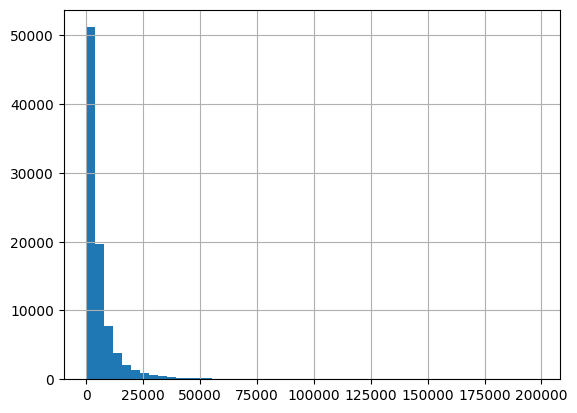

In [36]:
master[master['current_amount'] < 200000]['current_amount'].hist(bins=50)

<Axes: >

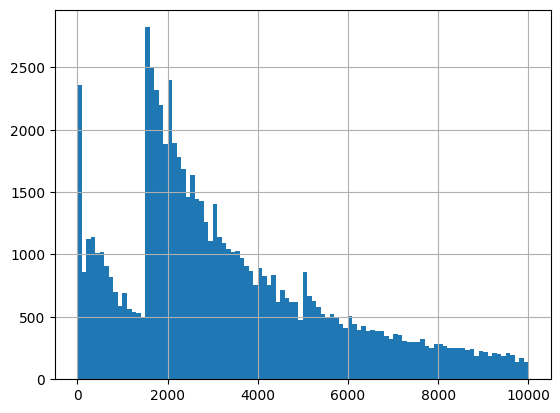

In [37]:
#zoomed in
master[master['current_amount'] < 10000]['current_amount'].hist(bins=100)

In [38]:
#reassign extreme values for amount raised to various cutoffs
for cap in [100000, 200000, 300000, 400000, 500000, 1000000]:
    var = 'current_amount_capped_{0}'.format(cap)
    master[var] = [x for x in master['current_amount']]
    master.loc[master['current_amount'] > cap, var] = cap

In [38]:
# master['current_amount_capped_100000'].describe()

# master['current_amount_capped_200000'].describe()

# master['current_amount_capped_300000'].describe()

# master['current_amount_capped_400000'].describe()

# master['current_amount_capped_500000'].describe()

# master['current_amount_capped_1000000'].describe()

### Box-cox transformation for amount sought

<Axes: >

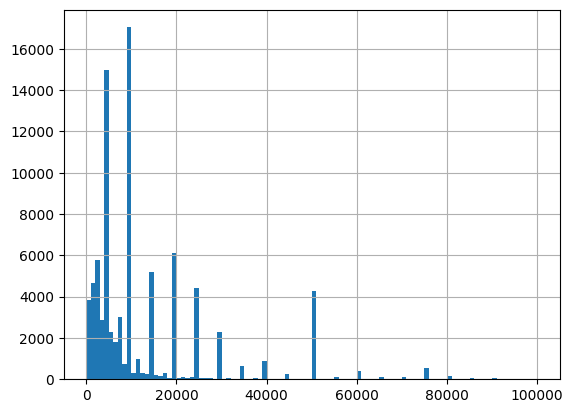

In [39]:
master[master['goal_amount'] < 100000]['goal_amount'].hist(bins=100)

In [40]:
master['goal_amount'].describe()

count    8.964500e+04
mean     6.481908e+04
std      5.705713e+06
min      1.000000e+00
25%      5.000000e+03
50%      1.000000e+04
75%      2.000000e+04
max      1.000000e+09
Name: goal_amount, dtype: float64

In [41]:
master['goal_amount_boxcox'] = scipy.stats.boxcox(master['goal_amount'])[0]

<Axes: >

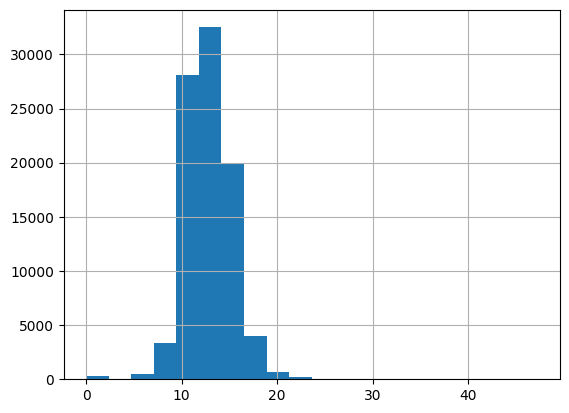

In [42]:
master['goal_amount_boxcox'].hist(bins=20)

In [43]:
master.loc[master['per_raised'] > 100,].shape

(12695, 120)

In [44]:
12695/89645

0.14161414468180045

# Table 1: Characteristics of study sample

In [45]:
master.shape

(89645, 120)

In [46]:
#define frequency and percent function

def FreqPer(var, df, sort_idx=False):
    if sort_idx:
        df = pd.concat([df[var].value_counts(),df[var].value_counts(normalize=True)*100], axis=1).sort_index()
    else:
        df = pd.concat([df[var].value_counts(),df[var].value_counts(normalize=True)*100], axis=1)
    df.columns = ['freq','percent']
    return df

### Frequency of year

In [47]:
FreqPer('year', master, True)

,freq,percent
2010,6,0.006693
2011,30,0.033465
2012,114,0.127168
2013,944,1.053043
2014,6668,7.438229
2015,16432,18.330080
2016,13139,14.656701
2017,10208,11.387138
2018,11235,12.532768
2019,15730,17.546991


In [48]:
#2010-2013
FreqPer('year', master, True).iloc[:4].apply(lambda x: sum(x), axis=0)

freq       1094.000000
percent       1.220369
dtype: float64

In [49]:
#2014-2017
FreqPer('year', master, True).iloc[4:8].apply(lambda x: sum(x), axis=0)

freq       46447.000000
percent       51.812148
dtype: float64

In [50]:
#2018-2020
FreqPer('year', master, True).iloc[8:].apply(lambda x: sum(x), axis=0)

freq       42104.000000
percent       46.967483
dtype: float64

### Number of unique disease categories per campaign

In [51]:
er['url'].nunique()

74016

In [52]:
#first subset data and convert present/absent back to integer
master_disease_int = master[master.columns[master.columns.str.startswith('d_')]].replace({'Present':1,'Absent':0})
master_disease_int['any_disease_sum'] = master_disease_int.apply(lambda x: x.sum(), axis=1)

In [53]:
master_disease_int[master_disease_int['any_disease_sum']>0].shape

(74016, 12)

In [54]:
any_disease_sum = FreqPer('any_disease_sum', master_disease_int, True)

In [55]:
any_disease_sum.iloc[:3,]

,freq,percent
0,15629,17.434324
1,49080,54.749289
2,15921,17.760054


In [56]:
#3+ categories
any_disease_sum.iloc[3:,].apply(lambda x: sum(x), axis=0)

freq       9015.000000
percent      10.056333
dtype: float64

### Frequency of disease categories (not mutually exclusive)

In [57]:
#rename mental health disorders
master['primary_disease_cat'].replace({'Mental and substance use disorders':'Mental health disorders'}, inplace=True)
#placeholder variable for no disease
master['no_disease_count'] = ['Absent' for x in master['url']]
#no disease county
master.loc[master['primary_disease_cat'] == 'No disease','no_disease_count'] = 'Present'

#subset disease pivot table to urls in master
disease_pivot_sub = disease_pivot[disease_pivot['url'].isin(master['url'].tolist())]
#rename categories
disease_pivot_sub.rename(columns=disease_cat_map, inplace=True)
#add disease sub to master data
disease_pivot_sub = disease_pivot_sub.merge(master[['url','no_disease_count']], on='url', how='left')
#rename no disease category
disease_pivot_sub.rename(columns={'no_disease_count':'No disease'}, inplace=True)


#melt disease categories to calculate mutually inclusive frequency
disease_cat_melt = disease_pivot_sub[disease_pivot_sub.columns[1:]].melt()

#only keep disease categories that were mentioned to include in frequency calculation
disease_cat_melt = disease_cat_melt[disease_cat_melt['value'] == 'Present']

#frequency calculation
any_disease_freq = pd.concat([disease_cat_melt['variable'].value_counts(),(disease_cat_melt['variable'].value_counts()/87449)*100], axis=1).reset_index()
#rename columns
any_disease_freq.columns = ['Disease category','Any disease freq','Any disease percent']

In [58]:
any_disease_freq

,Disease category,Any disease freq,Any disease percent
0,Neoplasms,38221,43.706618
1,Injuries and external causes,18087,20.682912
2,No disease,15629,17.872131
3,Cardiovascular diseases,11923,13.634233
4,Infections,8742,9.996684
5,Nervous system diseases,7705,8.810850
6,Musculoskeletal diseases,5594,6.396871
7,Mental health disorders,4838,5.532367
8,Respiratory diseases,4836,5.530080
9,Gastrointestinal diseases,4746,5.427163


# Figure 1: Amount raised by NDI

### Number of counties in each quartile

PCA was performed using the "06-PCA.R" file in this repository: https://github.com/sdoerstling/medical_crowdfunding_methods/tree/main

In [59]:
pca = pd.read_csv('../data/census/census_w_factor_weights.csv')

In [60]:
colnames = pca.columns.to_list()
cols_to_sum = [i for i in colnames if 'weighted' in i]

In [61]:
pca['sum'] = 0
for c in cols_to_sum:
    pca['sum'] += pca[c]

In [62]:
cols_to_sum.append('state_county_fips')
cols_to_sum.append('sum')
pca = pca[cols_to_sum]

In [63]:
census = pd.read_csv('../data/census/all_vars_by_county.csv')

In [64]:
pca['standardized_ndi'] = preprocessing.scale(pca['sum'])
pca = pd.merge(pca, census, how='left', on='state_county_fips')

QUANTS = (np.quantile(pca['standardized_ndi'].values, [.25, .5, .75]))

def _get_quantile(x):
    if x <= QUANTS[0]:
        return 1
    if x > QUANTS[0] and x <= QUANTS[1]:
        return 2
    if x > QUANTS[1] and x <= QUANTS[2]:
        return 3
    if x > QUANTS[2]:
        return 4
    
cols_to_drop = [c for c in pca.columns.to_list() if 'weighted' in c]

pca['ndi_quantile'] = pca['standardized_ndi'].apply(_get_quantile)

pca.drop(columns = cols_to_drop, inplace=True)

In [65]:
print(pca.shape)
print(pca['state_county_fips'].nunique())

(3142, 58)
3142


In [66]:
pca['ndi_quantile'].value_counts()

4    786
1    786
2    785
3    785
Name: ndi_quantile, dtype: int64

### Number of campaigns in each quartile

In [67]:
FreqPer('ndi_quantile', master, True)

,freq,percent
1,55895,62.351498
2,20491,22.857940
3,9816,10.949858
4,3443,3.840705


### Total population of all counties in each NDI quartile

In [68]:
pd.DataFrame(pca.groupby('ndi_quantile')['total_population'].sum()/1000000)

,total_population
ndi_quantile,
1,182.478809
2,76.076263
3,44.306814
4,21.835909


In [69]:
total_pop = pd.DataFrame(pca.groupby('ndi_quantile')['total_population'].sum()/1000000)\
    ['total_population'].sum()

In [70]:
pd.DataFrame(pca.groupby('ndi_quantile')['total_population'].sum()/1000000)\
    ['total_population']/total_pop * 100

ndi_quantile
1    56.199584
2    23.429867
3    13.645554
4     6.724995
Name: total_population, dtype: float64

### Amount raised by NDI quantile

In [71]:
ndi_amt = master[['current_amount','ndi_quantile']].groupby('ndi_quantile').agg('sum')
ndi_amt.reset_index(inplace=True)
total_spending = master['current_amount'].sum()
ndi_amt['percent_amt_ndi'] = (ndi_amt['current_amount']/total_spending)*100

In [72]:
ndi_amt

,ndi_quantile,current_amount,percent_amt_ndi
0,1,402731981.0,70.043358
1,2,112038951.0,19.485873
2,3,46008293.0,8.001786
3,4,14196039.0,2.468983


In [73]:
ndi = pd.DataFrame(pca.groupby('ndi_quantile')['total_population'].sum())

total_pop = pd.DataFrame(pca.groupby('ndi_quantile')['total_population'].sum())\
    ['total_population'].sum()

ndi['total_population_percent'] = round(ndi['total_population']/total_pop * 100,1)

ndi['campaign'] = master['ndi_quantile'].value_counts()

ndi['campaign_percent'] = round(master['ndi_quantile'].value_counts(normalize = True) * 100,1)

ndi['current_amount'] = master[['current_amount','ndi_quantile']].groupby('ndi_quantile').agg('sum')['current_amount']

total_spending = master['current_amount'].sum()

ndi['current_amount_percent'] = round(ndi['current_amount']/total_spending * 100,1)

ndi.reset_index(inplace=True)

ndi_raw = ndi[['ndi_quantile','total_population','campaign','current_amount']]
ndi_percent = ndi[['ndi_quantile','total_population_percent','campaign_percent','current_amount_percent']]

In [74]:
#d = ndi_percent.melt('ndi_quantile')

ndi_percent = ndi_percent.set_index('ndi_quantile').T.reset_index()
ndi_percent.columns = ['variable',
                       'ADI quartile 1 (least deprived)', 
                       'ADI quartile 2', 
                       'ADI quartile 3', 
                       'ADI quartile 4 (most deprived)']

In [75]:
ndi_percent['variable'] = ndi_percent['variable'].replace({"total_population_percent":"Total population",
                                                          "campaign_percent":"Number of campaigns",
                                                          "current_amount_percent":"Amount raised"})

In [76]:
ndi_percent

,variable,ADI quartile 1 (least deprived),ADI quartile 2,ADI quartile 3,ADI quartile 4 (most deprived)
0,Total population,56.2,23.4,13.6,6.7
1,Number of campaigns,62.4,22.9,10.9,3.8
2,Amount raised,70.0,19.5,8.0,2.5


### Plot

<Figure size 640x480 with 0 Axes>

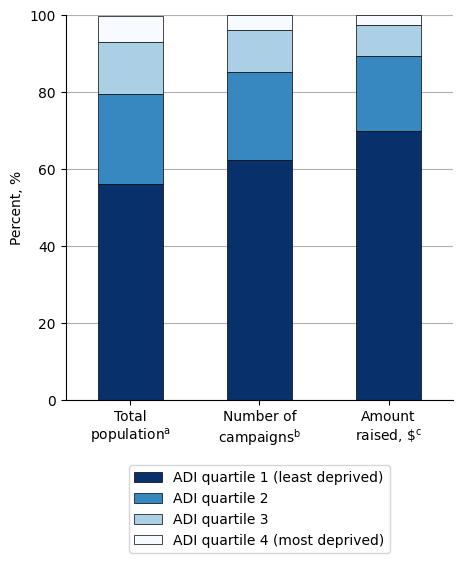

In [77]:
sns.reset_defaults()

f = plt.figure()

ax = ndi_percent.plot(x='variable',
                 kind='bar',
                 stacked=True,
                edgecolor="black",
                 linewidth=0.5,
                      colormap = sns.color_palette("Blues_r", as_cmap=True),
                figsize=(5,5))

plt.xlabel("")
plt.ylabel("Percent, %")
plt.xticks(range(3),['Total\n$\mathregular{population^{a}}$',
                     'Number of\n$\mathregular{campaigns^{b}}$',
                     'Amount\nraised, \$$\mathregular{^{c}}$'],rotation=0, ha='center')
plt.ylim(0,100)

ax.grid(axis='y')
ax.set_axisbelow(True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

sns.despine()

#plt.savefig("../plots/figure_1.pdf", bbox_inches='tight')

plt.show()


### Bonus: visualize NDI against income

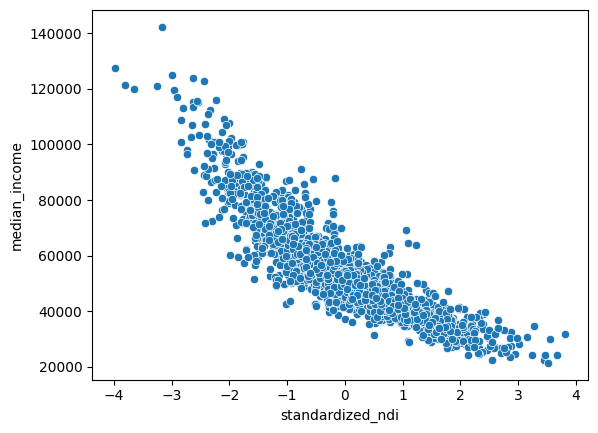

In [79]:
#visualize standardized ndi
sns.scatterplot(data=pca, x='standardized_ndi', y='median_income')
plt.show()

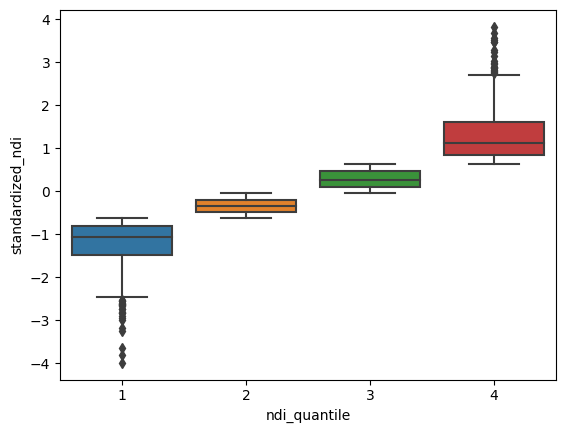

In [80]:
sns.boxplot(data=pca, x='ndi_quantile', y='standardized_ndi')
plt.show()

In [81]:
pca.groupby('ndi_quantile')['median_income'].agg(np.median)

ndi_quantile
1    66571.0
2    54902.0
3    48531.0
4    39787.0
Name: median_income, dtype: float64

# Dataset for R

In [82]:
#show dtypes for. variables included in regression
regression_variables = ['current_amount',
                        'current_amount_capped_100000',
                        'current_amount_capped_200000',
                        'current_amount_capped_300000',
                        'current_amount_capped_400000',
                        'current_amount_capped_500000',
                        'current_amount_capped_1000000',
                        'donation_count',
                        'donation_mean',
                        'd_cardiovascular_diseases', 
                        'd_endocrine_diseases', 
                        'd_gastrointestinal_diseases', 
                        'd_genitourinary_diseases', 
                        'd_infections', 
                        'd_injuries_and_external_causes', 
                        'd_mental_and_substance_use_disorders',
                        'd_musculoskeletal_diseases', 
                        'd_neoplasms', 
                        'd_nervous_system_diseases', 
                        'd_respiratory_diseases', 
                        'year_int',
                        'goal_amount',
                        'goal_amount_boxcox',
                        'ndi_quantile']

master[regression_variables].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89645 entries, 0 to 89644
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   current_amount                        89645 non-null  float64
 1   current_amount_capped_100000          89645 non-null  float64
 2   current_amount_capped_200000          89645 non-null  float64
 3   current_amount_capped_300000          89645 non-null  float64
 4   current_amount_capped_400000          89645 non-null  float64
 5   current_amount_capped_500000          89645 non-null  float64
 6   current_amount_capped_1000000         89645 non-null  float64
 7   donation_count                        89645 non-null  int64  
 8   donation_mean                         89608 non-null  float64
 9   d_cardiovascular_diseases             89645 non-null  object 
 10  d_endocrine_diseases                  89645 non-null  object 
 11  d_gastrointesti

In [83]:
#master[regression_variables].to_csv('../cf_data_for_regressions.csv', index=False)

# Regression analysis of amount raised

- data were exported, and final analyses were run in R

### Data structure

In [84]:
#show dtypes for. variables included in regression

master[regression_variables].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89645 entries, 0 to 89644
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   current_amount                        89645 non-null  float64
 1   current_amount_capped_100000          89645 non-null  float64
 2   current_amount_capped_200000          89645 non-null  float64
 3   current_amount_capped_300000          89645 non-null  float64
 4   current_amount_capped_400000          89645 non-null  float64
 5   current_amount_capped_500000          89645 non-null  float64
 6   current_amount_capped_1000000         89645 non-null  float64
 7   donation_count                        89645 non-null  int64  
 8   donation_mean                         89608 non-null  float64
 9   d_cardiovascular_diseases             89645 non-null  object 
 10  d_endocrine_diseases                  89645 non-null  object 
 11  d_gastrointesti

### Estimate tweedie index parameter

- done in R (filename = "estimate_tweedie_variance_power.R"), uses tweedie.profile function of tweedie package
- output: $p.max [1] 1.718367

### Sensitivity analyses

In [108]:
def ModelResults(model):
    fit = model.fit()
    html = fit.summary().as_html()
    df = pd.read_html(html, header=0)[1]
    df.columns = ['var','coef','std err','z','P>|z|','[0.025','0.975]']
    return df[['var','coef','z','P>|z|']]

sensitivity_analysis = {}

for amount_sought in ['goal_amount','goal_amount_boxcox']:
    
    sensitivity_analysis[amount_sought] = {}
    
    amount_raised_ = ['current_amount']
    
    for cap in [100000, 200000, 300000, 400000, 500000, 1000000]:
        amount_raised_.append('current_amount_capped_{0}'.format(cap))
    
    for amount_raised in amount_raised_:
        formula = '''{0} ~ 
            C(d_cardiovascular_diseases, Treatment(reference='Absent')) + 
            C(d_endocrine_diseases, Treatment(reference='Absent')) + 
            C(d_gastrointestinal_diseases, Treatment(reference='Absent')) + 
            C(d_genitourinary_diseases, Treatment(reference='Absent')) + 
            C(d_infections, Treatment(reference='Absent')) + 
            C(d_injuries_and_external_causes, Treatment(reference='Absent')) + 
            C(d_mental_and_substance_use_disorders, Treatment(reference='Absent')) + 
            C(d_musculoskeletal_diseases, Treatment(reference='Absent')) + 
            C(d_neoplasms, Treatment(reference='Absent')) + 
            C(d_nervous_system_diseases, Treatment(reference='Absent')) + 
            C(d_respiratory_diseases, Treatment(reference='Absent')) +
            year_int + 
            {1} +
            C(ndi_quantile, Treatment(reference=4))
            '''.format(amount_raised, amount_sought).replace('\n','')
        
        print(amount_sought + ' // ' + amount_raised)
        
        model = sm.GLM.from_formula(formula=formula, 
                            data=master, 
                            family=sm.genmod.families.family.Tweedie(var_power = 1.72, eql=False))
        
        res = ModelResults(model)
        
        sensitivity_analysis[amount_sought][amount_raised] = res

goal_amount // current_amount
goal_amount // current_amount_capped_100000
goal_amount // current_amount_capped_200000
goal_amount // current_amount_capped_300000
goal_amount // current_amount_capped_400000
goal_amount // current_amount_capped_500000
goal_amount // current_amount_capped_1000000
goal_amount_boxcox // current_amount
goal_amount_boxcox // current_amount_capped_100000
goal_amount_boxcox // current_amount_capped_200000
goal_amount_boxcox // current_amount_capped_300000
goal_amount_boxcox // current_amount_capped_400000
goal_amount_boxcox // current_amount_capped_500000
goal_amount_boxcox // current_amount_capped_1000000


In [109]:
print(sensitivity_analysis.keys())
print(sensitivity_analysis['goal_amount'].keys())
print(sensitivity_analysis['goal_amount_boxcox'].keys())

dict_keys(['goal_amount', 'goal_amount_boxcox'])
dict_keys(['current_amount', 'current_amount_capped_100000', 'current_amount_capped_200000', 'current_amount_capped_300000', 'current_amount_capped_400000', 'current_amount_capped_500000', 'current_amount_capped_1000000'])
dict_keys(['current_amount', 'current_amount_capped_100000', 'current_amount_capped_200000', 'current_amount_capped_300000', 'current_amount_capped_400000', 'current_amount_capped_500000', 'current_amount_capped_1000000'])


In [111]:
# to view individual result dfs, enter:
# 1) whether you want untransformed goal amount or box-cox transformed goal amount
# 2) then select which cutoff you want for goal amount
# For example:
sensitivity_analysis['goal_amount']['current_amount_capped_100000']

,var,coef,z,P>|z|
0,Intercept,1.663857e+02,32.999,0.000
1,"C(d_cardiovascular_diseases, Treatment(referen...",5.740000e-02,3.816,0.000
2,"C(d_endocrine_diseases, Treatment(reference='A...",-1.134000e-01,-4.450,0.000
3,"C(d_gastrointestinal_diseases, Treatment(refer...",-8.700000e-03,-0.382,0.703
4,"C(d_genitourinary_diseases, Treatment(referenc...",-3.350000e-02,-1.451,0.147
5,"C(d_infections, Treatment(reference='Absent'))...",1.290000e-01,7.522,0.000
6,"C(d_injuries_and_external_causes, Treatment(re...",2.191000e-01,17.146,0.000
7,"C(d_mental_and_substance_use_disorders, Treatm...",-7.820000e-02,-3.448,0.001
8,"C(d_musculoskeletal_diseases, Treatment(refere...",-4.520000e-02,-2.111,0.035
9,"C(d_neoplasms, Treatment(reference='Absent'))[...",3.546000e-01,33.230,0.000


### Final regression

- done in R (filename = "estimate_tweedie_variance_power.R")

# Figure 2: Regression model of amount raised

In [85]:
formula_final = '''current_amount ~ 
C(d_cardiovascular_diseases, Treatment(reference='Absent')) + 
C(d_endocrine_diseases, Treatment(reference='Absent')) + 
C(d_gastrointestinal_diseases, Treatment(reference='Absent')) + 
C(d_genitourinary_diseases, Treatment(reference='Absent')) + 
C(d_infections, Treatment(reference='Absent')) + 
C(d_injuries_and_external_causes, Treatment(reference='Absent')) + 
C(d_mental_and_substance_use_disorders, Treatment(reference='Absent')) + 
C(d_musculoskeletal_diseases, Treatment(reference='Absent')) + 
C(d_neoplasms, Treatment(reference='Absent')) + 
C(d_nervous_system_diseases, Treatment(reference='Absent')) + 
C(d_respiratory_diseases, Treatment(reference='Absent')) +
year_int + 
goal_amount_boxcox +
C(ndi_quantile, Treatment(reference=4))'''.replace('\n','')
        
model = sm.GLM.from_formula(formula=formula_final, 
                            data=master, 
                            family=sm.genmod.families.family.Tweedie(var_power = 1.72, eql=False))

In [86]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         current_amount   No. Observations:                89645
Model:                            GLM   Df Residuals:                    89628
Model Family:                 Tweedie   Df Model:                           16
Link Function:                    Log   Scale:                          31.347
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 25 Mar 2025   Deviance:                   9.4683e+05
Time:                        14:51:44   Pearson chi2:                 2.81e+06
No. Iterations:                    95   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                           150.4368      5.678     26.494      0.000     139.308     161.566
C(d_cardiovascular_diseases, Treatment(reference='Absent'))[T.Present]                0.0197      0.017      1.170      0.242      -0.013       0.053
C(d_endocrine_diseases, Treatment(reference='Absent'))[T.Present]                    -0.1174      0.028     -4.130      0.000      -0.173      -0.062
C(d_gastrointestinal_diseases, Treatment(reference='Absent'))[T.Present]             -0.0157      0.025     -0.619      0.536      -0.065       0.034
C(d_genitourinary_diseases, Treatment(reference='Absent'))[T.Present]                -0.0669      0.026     -2.599      0.009      -0.117      -0.016
C(d_infections, Treatment(reference='Absent'))[T.Present]                             0.0611      0.019      3.182      0.001       0.023       0.099
C(d_injuries_and_external_causes, Treatment(reference='Absent'))[T.Present]           0.1217      0.014      8.487      0.000       0.094       0.150
C(d_mental_and_substance_use_disorders, Treatment(reference='Absent'))[T.Present]    -0.0796      0.025     -3.136      0.002      -0.129      -0.030
C(d_musculoskeletal_diseases, Treatment(reference='Absent'))[T.Present]              -0.0326      0.024     -1.367      0.172      -0.079       0.014
C(d_neoplasms, Treatment(reference='Absent'))[T.Present]                              0.2211      0.012     18.346      0.000       0.197       0.245
C(d_nervous_system_diseases, Treatment(reference='Absent'))[T.Present]                0.0871      0.020      4.314      0.000       0.048       0.127
C(d_respiratory_diseases, Treatment(reference='Absent'))[T.Present]                   0.0874      0.025      3.519      0.000       0.039       0.136
C(ndi_quantile, Treatment(reference=4))[T.1]                                          0.3940      0.031     12.684      0.000       0.333       0.455
C(ndi_quantile, Treatment(reference=4))[T.2]                                          0.1902      0.033      5.848      0.000       0.126       0.254
C(ndi_quantile, Treatment(reference=4))[T.3]                                          0.0814      0.035      2.327      0.020       0.013       0.150
year_int                                                                             -0.0718      0.003    -25.531      0.000      -0.077      -0.066
goal_amount_boxcox                                                                    0.1999      0.002     87.307      0.000       0.195       0.204
===================================================================================

### Regression functions

In [88]:
def ModelResults(model):
    fit = model.fit()
    html = fit.summary().as_html()
    df = pd.read_html(html, header=0)[1]
    df.columns = ['var','coef','std err','z','P>|z|','[0.025','0.975]']
    return df

In [89]:
def GetBeta(df):
    beta = df['coef'].round(2).astype(str) + ' (' + df['std err'].round(2).astype(str) + ')'
    res = pd.concat([df['var'],beta],axis=1)
    res.columns = ['var','beta_se']
    return res

In [90]:
def GetPer(df):
    '''
    calculates expected percent change in dependent variable assuming log link function
    '''
    exp_coef = (np.exp(df['coef']) - 1) * 100
    exp_low = (np.exp(df['[0.025']) - 1) * 100
    exp_high = (np.exp(df['0.975]']) - 1) * 100
    
    res = pd.concat([df['var'],exp_coef,exp_low,exp_high],axis=1)
    res.columns = ['var','per','ci_low','ci_high']
    return res

In [91]:
def GetPerFormatted(df):
    '''
    References:
    https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/
    https://stats.stackexchange.com/questions/431120/how-to-interpret-parameters-of-glm-output-with-gamma-log-link
    '''
    exp_coef = (np.exp(df['coef']) - 1) * 100
    exp_low = (np.exp(df['[0.025']) - 1) * 100
    exp_high = (np.exp(df['0.975]']) - 1) * 100
    
    r = exp_coef.round(1).astype(str) + ' (' + exp_low.round(1).astype(str) + ', ' + exp_high.round(1).astype(str) + ')'
    res = pd.concat([df['var'],r],axis=1)
    res.columns = ['var','per_formatted']

    return res

In [92]:
model_res = ModelResults(model)
beta_se = GetBeta(model_res)
per = GetPer(model_res)
per_formatted = GetPerFormatted(model_res)

### Regression output for table

In [93]:
regression_table = model_res[['var','z','P>|z|']].merge(beta_se, on='var')
regression_table = regression_table.merge(per_formatted, on='var')

In [94]:
regression_table

,var,z,P>|z|,beta_se,per_formatted
0,Intercept,26.494,0.000,150.44 (5.68),"2.1571091210329786e+67 (3.167347289460255e+62,..."
1,"C(d_cardiovascular_diseases, Treatment(referen...",1.170,0.242,0.02 (0.02),"2.0 (-1.3, 5.4)"
2,"C(d_endocrine_diseases, Treatment(reference='A...",-4.130,0.000,-0.12 (0.03),"-11.1 (-15.9, -6.0)"
3,"C(d_gastrointestinal_diseases, Treatment(refer...",-0.619,0.536,-0.02 (0.02),"-1.6 (-6.3, 3.5)"
4,"C(d_genitourinary_diseases, Treatment(referenc...",-2.599,0.009,-0.07 (0.03),"-6.5 (-11.0, -1.6)"
5,"C(d_infections, Treatment(reference='Absent'))...",3.182,0.001,0.06 (0.02),"6.3 (2.3, 10.4)"
6,"C(d_injuries_and_external_causes, Treatment(re...",8.487,0.000,0.12 (0.01),"12.9 (9.9, 16.2)"
7,"C(d_mental_and_substance_use_disorders, Treatm...",-3.136,0.002,-0.08 (0.02),"-7.7 (-12.1, -3.0)"
8,"C(d_musculoskeletal_diseases, Treatment(refere...",-1.367,0.172,-0.03 (0.02),"-3.2 (-7.6, 1.4)"
9,"C(d_neoplasms, Treatment(reference='Absent'))[...",18.346,0.000,0.22 (0.01),"24.7 (21.8, 27.8)"


In [95]:
# regression_table.to_csv("../figure_2_data.txt", sep="\t", index=False)

### Formatting data for plot

In [96]:
# subset disease categories and NDI quartile
reg_plot = per.iloc[1:15,]

In [97]:
reg_plot

,var,per,ci_low,ci_high
1,"C(d_cardiovascular_diseases, Treatment(referen...",1.989533,-1.291586,5.442965
2,"C(d_endocrine_diseases, Treatment(reference='A...",-11.077057,-15.886239,-6.011711
3,"C(d_gastrointestinal_diseases, Treatment(refer...",-1.557740,-6.293254,3.458461
4,"C(d_genitourinary_diseases, Treatment(referenc...",-6.471127,-11.041481,-1.587268
5,"C(d_infections, Treatment(reference='Absent'))...",6.300521,2.326654,10.406630
6,"C(d_injuries_and_external_causes, Treatment(re...",12.941523,9.855975,16.183424
7,"C(d_mental_and_substance_use_disorders, Treatm...",-7.651433,-12.102603,-2.955447
8,"C(d_musculoskeletal_diseases, Treatment(refere...",-3.207435,-7.596008,1.409846
9,"C(d_neoplasms, Treatment(reference='Absent'))[...",24.744817,21.774404,27.762131
10,"C(d_nervous_system_diseases, Treatment(referen...",9.100577,4.917066,13.541702


In [98]:
# add new row for reference category of NDI quartile, create dummy confidence intervals for data uniformity
new_row = pd.DataFrame({'var': ['4 (most deprived)'], 'per': [0], 'ci_low': [-0.0001], 'ci_high': [0.0001]})

reg_plot = pd.concat([reg_plot, new_row], axis=0, ignore_index=True)

In [99]:
new_var = [
    'Cardiovascular diseases',
    'Endocrine diseases',
    'Gastrointestinal diseases',
    'Genitourinary diseases',
    'Infections',
    'Injuries and external causes',
    'Mental health disorders',
    'Musculoskeletal diseases',
    'Neoplasms',
    'Nervous system diseases',
    'Respiratory diseases',
    '1 (least deprived)',
    '2',
    '3',
    '4 (most deprived)'
]

In [100]:
reg_plot['var'] = new_var

In [101]:
reg_plot

,var,per,ci_low,ci_high
0,Cardiovascular diseases,1.989533,-1.291586,5.442965
1,Endocrine diseases,-11.077057,-15.886239,-6.011711
2,Gastrointestinal diseases,-1.557740,-6.293254,3.458461
3,Genitourinary diseases,-6.471127,-11.041481,-1.587268
4,Infections,6.300521,2.326654,10.406630
5,Injuries and external causes,12.941523,9.855975,16.183424
6,Mental health disorders,-7.651433,-12.102603,-2.955447
7,Musculoskeletal diseases,-3.207435,-7.596008,1.409846
8,Neoplasms,24.744817,21.774404,27.762131
9,Nervous system diseases,9.100577,4.917066,13.541702


#### Disease categories plot

In [102]:
disease_plot = reg_plot.iloc[:11,].sort_values('per', ascending=False)
disease_plot

,var,per,ci_low,ci_high
8,Neoplasms,24.744817,21.774404,27.762131
5,Injuries and external causes,12.941523,9.855975,16.183424
10,Respiratory diseases,9.133313,3.977048,14.568189
9,Nervous system diseases,9.100577,4.917066,13.541702
4,Infections,6.300521,2.326654,10.406630
0,Cardiovascular diseases,1.989533,-1.291586,5.442965
2,Gastrointestinal diseases,-1.557740,-6.293254,3.458461
7,Musculoskeletal diseases,-3.207435,-7.596008,1.409846
3,Genitourinary diseases,-6.471127,-11.041481,-1.587268
6,Mental health disorders,-7.651433,-12.102603,-2.955447


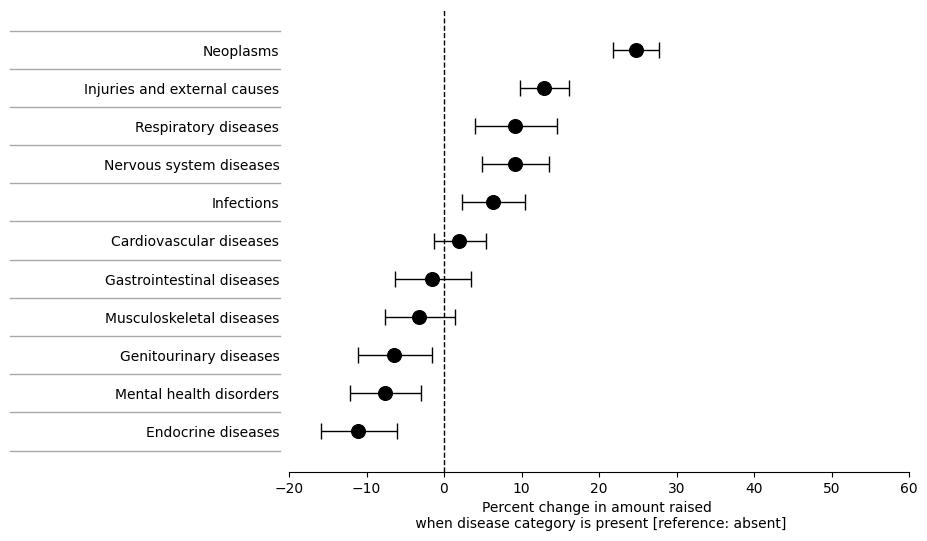

In [103]:
# figure setup
# sns.set(style="ticks", font_scale=1.4)
sns.reset_defaults()
plt.figure(figsize=(8, 6))

# plot
ax = sns.scatterplot(y='var',x='per', data=disease_plot, s=100, 
                     zorder=10, color='black', 
                     edgecolor='black')

plt.errorbar(y=disease_plot['var'],
             x=disease_plot['per'], 
             xerr=[disease_plot['per']-disease_plot['ci_low'],disease_plot['ci_high']-disease_plot['per']], 
             fmt='none', c= 'black', capsize=6, linewidth=1)

# format
ax.set_xlabel('Percent change in amount raised \n when disease category is present [reference: absent]')
ax.set_title('')
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.axvline(x=0, linestyle='--', color='black', linewidth=1, zorder=0)
ax.tick_params(left=False)
ax.set(xlim=(-20,60)) # limits based on upper end of CI for NDI quartile
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

trans = ax.get_yaxis_transform()
for x in range(-5,115,10):
    i = x/10
    ax.plot([-.45,-.015],[i,i], color="darkgray", transform=trans, clip_on=False, linewidth=1)  

sns.despine(trim=True, left=True)

plt.show()

#### NDI plot

In [104]:
ndi_plot = reg_plot.iloc[11:15,]
ndi_plot

,var,per,ci_low,ci_high
11,1 (least deprived),48.290055,39.514730,57.617338
12,2,20.949147,13.428217,28.917180
13,3,8.480473,1.308487,16.183424
14,4 (most deprived),0.000000,-0.000100,0.000100


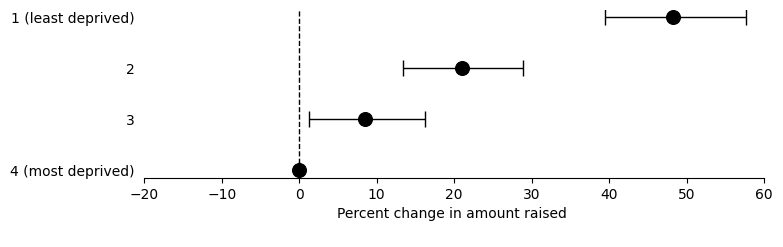

In [105]:
# figure setup
# sns.set(style="ticks", font_scale=1.4)
plt.figure(figsize=(8, 2.18))

# plot
plt.errorbar(y=ndi_plot['var'],
             x=ndi_plot['per'], 
             xerr=[ndi_plot['per']-ndi_plot['ci_low'],ndi_plot['ci_high']-ndi_plot['per']], 
             fmt='none', c= 'black', capsize=6, linewidth=1)

# format
ax = sns.scatterplot(y='var',x='per', data=ndi_plot, s=100, 
                     zorder=10, color='black', 
                     edgecolor='black')

ax.set_xlabel('Percent change in amount raised \n')
ax.set_title('')
ax.set_axisbelow(True)
ax.set_ylabel('')
ax.axvline(x=0, linestyle='--', color='black', linewidth=1, zorder=0)
ax.tick_params(left=False)
ax.set(xlim=(-20,60))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

# trans = ax.get_yaxis_transform()
# for x in range(65,115,10):
#     i = x/10
#     ax.plot([-.45,-.015],[i,i], color="darkgray", transform=trans, clip_on=False, linewidth=1)

#ax.plot([-.45,-.015],[6.5,6.5], color="darkgray", transform=trans, clip_on=False, linewidth=1)

sns.despine(trim=True, left=True)

plt.show()

#### Combined plot

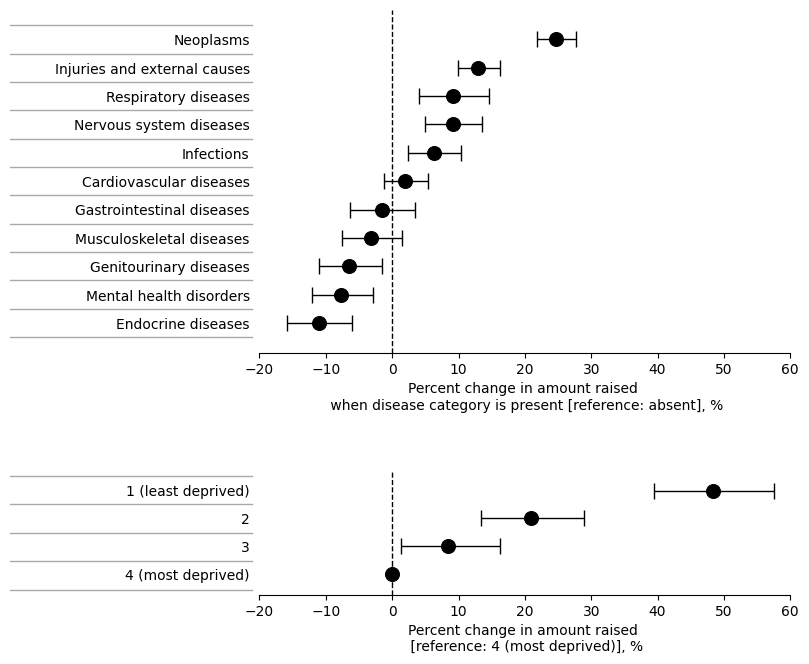

In [106]:

sns.reset_defaults()
# figure setup
fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[11,4]}, figsize=(8,7))
#sns.set(style="ticks", font_scale=1.1)


# disease plot
sns.scatterplot(y='var',x='per', data=disease_plot, s=100, 
                     zorder=10, color='black', 
                     edgecolor='black', ax=axes[0])

axes[0].errorbar(y=disease_plot['var'],
             x=disease_plot['per'], 
             xerr=[disease_plot['per']-disease_plot['ci_low'],disease_plot['ci_high']-disease_plot['per']], 
             fmt='none', c= 'black', capsize=6, linewidth=1)

axes[0].set_xlabel('Percent change in amount raised \n when disease category is present [reference: absent], %')
axes[0].set_title('')
axes[0].set_axisbelow(True)
axes[0].set_ylabel('')
axes[0].axvline(x=0, linestyle='--', color='black', linewidth=1, zorder=0)
axes[0].tick_params(left=False)
axes[0].set(xlim=(-20,60))
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(10))

trans = axes[0].get_yaxis_transform()
for x in range(-5,115,10):
    i = x/10
    axes[0].plot([-.47,-.015],[i,i], color="darkgray", transform=trans, clip_on=False, linewidth=1)  

# NDI plot
sns.scatterplot(y='var',x='per', data=ndi_plot, s=100, 
                     zorder=10, color='black', 
                     edgecolor='black', ax=axes[1])

axes[1].errorbar(y=ndi_plot['var'],
             x=ndi_plot['per'], 
             xerr=[ndi_plot['per']-ndi_plot['ci_low'],ndi_plot['ci_high']-ndi_plot['per']], 
             fmt='none', c= 'black', capsize=6, linewidth=1)

axes[1].set_xlabel('Percent change in amount raised \n [reference: 4 (most deprived)], %')
axes[1].set_title('')
axes[1].set_axisbelow(True)
axes[1].set_ylabel('')
axes[1].axvline(x=0, linestyle='--', color='black', linewidth=1, zorder=0)
axes[1].tick_params(left=False)
axes[1].set(xlim=(-20,60))
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(10))

axes[1].plot([-.47,-.015],[15.4,15.4], color="darkgray", transform=trans, clip_on=False, linewidth=1) 
axes[1].plot([-.47,-.015],[16.4,16.4], color="darkgray", transform=trans, clip_on=False, linewidth=1) 
axes[1].plot([-.47,-.015],[17.4,17.4], color="darkgray", transform=trans, clip_on=False, linewidth=1) 
axes[1].plot([-.47,-.015],[18.4,18.4], color="darkgray", transform=trans, clip_on=False, linewidth=1) 
axes[1].plot([-.47,-.015],[19.4,19.4], color="darkgray", transform=trans, clip_on=False, linewidth=1) 

sns.despine(trim=True, left=True)

#axes[0].margins(0.05, 0.15)
axes[1].margins(0.05, 0.25)

fig.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.5)

# plt.savefig("../plots/figure_2.pdf", bbox_inches='tight')

plt.show()

# Regression analysis of donation count and amount

### Sensitivity analysis

- Sensitivity analysis and final implementation both done in R (filename = "donation_sensitivity_analysis.R")

# Supp Fig: Relative frequency of disease category per year

In [112]:
any_disease_cols_year = master.columns[master.columns.str.startswith('d_')].tolist() + ['year']
any_disease = master[any_disease_cols_year].replace({'Present':1,'Absent':0})

In [113]:
any_disease_year_long = pd.melt(any_disease, id_vars=['year'])
any_disease_year_long = any_disease_year_long[any_disease_year_long['value'] == 1]

In [114]:
any_disease_year_long['variable'].replace(disease_cat_map, inplace=True)

In [115]:
any_disease_time = pd.crosstab(any_disease_year_long['variable'],any_disease_year_long['year'])
any_disease_time = any_disease_time.apply(lambda r: r/r.sum(), axis=0).round(3) * 100
any_disease_time = any_disease_time.reset_index()
any_disease_time = pd.melt(any_disease_time, id_vars=['variable'], 
                           value_vars=["2010","2011","2012",'2013','2014','2015','2016','2017','2018','2019','2020']) 
any_disease_time.columns = ['any_disease_cat','year','value']

In [116]:
any_disease_time

,any_disease_cat,year,value
0,Cardiovascular diseases,2010,0.0
1,Endocrine diseases,2010,12.5
2,Gastrointestinal diseases,2010,0.0
3,Genitourinary diseases,2010,0.0
4,Infections,2010,0.0
...,...,...,...
116,Mental health disorders,2020,5.6
117,Musculoskeletal diseases,2020,4.8
118,Neoplasms,2020,30.7
119,Nervous system diseases,2020,6.0


<Figure size 640x480 with 0 Axes>

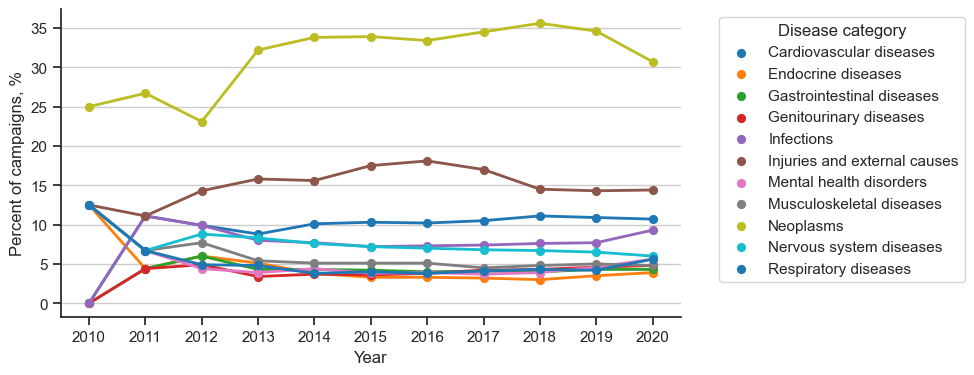

In [124]:
sns.set(style="ticks")
#plt.figure(figsize=(10, 6))
plt.figure(figsize=(8, 4))


ax = sns.pointplot(x='year', y='value', hue='any_disease_cat', data=any_disease_time, join=True, scale=0.75,
                  palette=sns.color_palette("tab10"))
ax.set_ylabel('Percent of campaigns, %')
ax.set_xlabel('Year')
ax.yaxis.grid(True)
#ax.set_title('Any disease category')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, title='Disease category')

sns.despine()
plt.show()

# plt.savefig("../plots/disease_cat_by_year.pdf", bbox_inches='tight')



# Supp Fig: Relative frequency of NDI by year

In [126]:
ndi_time = pd.crosstab(master['ndi_quantile'],master['year']).apply(lambda r: r/r.sum(), axis=0).round(3) * 100
ndi_time = ndi_time.reset_index()

ndi_time = pd.melt(ndi_time, id_vars=['ndi_quantile'], value_vars=["2010","2011","2012",'2013','2014','2015','2016','2017','2018','2019','2020']) 

ndi_time['ndi_quantile'].replace({1:'1 (least deprived)',4:'4 (most deprived)'}, inplace=True)


<Figure size 800x400 with 0 Axes>

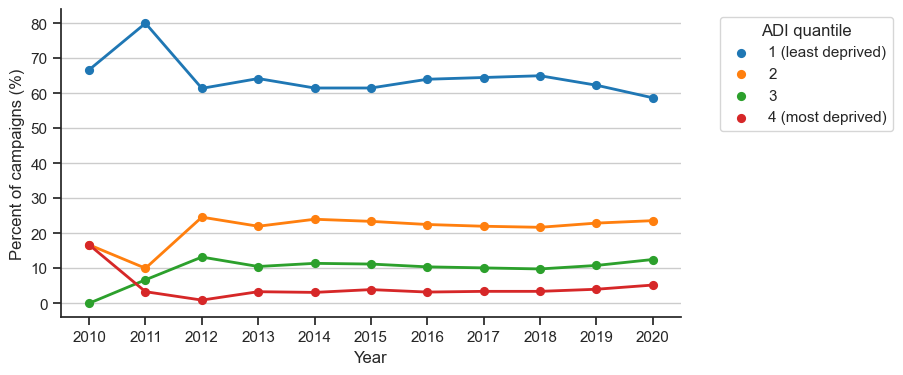

In [127]:
sns.set(style="ticks")
plt.figure(figsize=(8, 4))


ax = sns.pointplot(x='year', y='value', hue='ndi_quantile', data=ndi_time, join=True, scale=0.75,
                  palette=sns.color_palette("tab10"))
ax.set_ylabel('Percent of campaigns (%)')
ax.set_xlabel('Year')
ax.yaxis.grid(True)
#ax.set_title('Any disease category')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, title='ADI quantile')

sns.despine()

plt.show()
# plt.savefig("../plots/ndi_by_year.pdf", bbox_inches='tight')



# Supp Fig: Donation analysis

### Subset donation data to only those campaigns that are in master daata

Master data with financial outliers removed

In [128]:
# start_n = master.shape[0]

# current_amt_cutoff = master['current_amount'].quantile([.999]).tolist()[0]
# goal_amt_cutoff = master['goal_amount'].quantile([.999]).tolist()[0]
# donation_count_cutoff = master['donation_count'].quantile([.999]).tolist()[0]
# donation_amt_cutoff = master['donation_mean'].quantile([.999]).tolist()[0]

# master_fin_ex = master[master['current_amount'] < current_amt_cutoff]
# master_fin_ex = master_fin_ex[master_fin_ex['goal_amount'] < goal_amt_cutoff]
# master_fin_ex = master_fin_ex[master_fin_ex['donation_count'] < donation_count_cutoff]
# master_fin_ex = master_fin_ex[master_fin_ex['donation_mean'] < donation_amt_cutoff]

# financial_removed = start_n - master_fin_ex.shape[0]

# print(financial_removed)
# print(master_fin_ex.shape[0])

In [129]:
print(donations['url'].nunique())
print(master['url'].nunique())

90954
89645


In [130]:
donations = donations[donations['url'].isin(master['url'].tolist())]

In [131]:
print(donations['url'].nunique())
print(master['url'].nunique())

87759
89645


### Calculate date difference between campaign start and donation

In [132]:
def GetYMD(string):
    return str(string).split('T')[0]

In [133]:
#merge created at date and financial data with donations
donations = donations.merge(master[['url','created_at','current_amount','goal_amount','year']], on='url', how='left')

In [134]:
#extract date as yyyy-mm-dd format
donations.loc[:,'don_date_ymd'] = donations['don_date'].apply(GetYMD)
donations.loc[:,'created_at_ymd'] = donations['created_at'].apply(GetYMD)

In [135]:
#convert dates to datetime format
donations.loc[:,'don_date_ymd'] = pd.to_datetime(donations['don_date_ymd'])
donations.loc[:,'created_at_ymd'] = pd.to_datetime(donations['created_at_ymd'])

/var/folders/l8/8sbf_n294bz_vfhsdjvw6_s80000gn/T/ipykernel_47417/3525376282.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  donations.loc[:,'don_date_ymd'] = pd.to_datetime(donations['don_date_ymd'])
/var/folders/l8/8sbf_n294bz_vfhsdjvw6_s80000gn/T/ipykernel_47417/3525376282.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  donations.loc[:,'created_at_ymd'] = pd.to_datetime(donations['created_at_ymd'])


In [136]:
#get time delta
donations.loc[:,'time_delta'] = (donations['don_date_ymd'] - donations['created_at_ymd'])

In [137]:
#time delta in days
donations['time_delta_days'] = donations['time_delta']/np.timedelta64(1, 'D')

#time delta in months
donations['time_delta_months'] = donations['time_delta']/np.timedelta64(1, 'M')

#time delta in months rounded + 1 (e.g. 20 days = within 1 month)
donations['time_delta_months_whole'] = (donations['time_delta']//np.timedelta64(1, 'M')) + 1

### Sum donation amounts by month relative to start date

In [138]:
amt_raised_by_month = donations[['url','don_amt','time_delta_months_whole','year']] \
    .groupby(['url','time_delta_months_whole','year']).sum()
    

In [139]:
#reset index so multiindex are each individual columns with values for every row
amt_raised_by_month = amt_raised_by_month.reset_index()

In [140]:
#check that index is in the same order as time_delta_months_whole (i.e. both increasing together)
amt_raised_by_month.head(10)

,url,time_delta_months_whole,year,don_amt
0,https://www.gofundme.com/f/-AMYSTRONG-,1,2018,3205.0
1,https://www.gofundme.com/f/-AMYSTRONG-,2,2018,50.0
2,https://www.gofundme.com/f/-AMYSTRONG-,3,2018,410.0
3,https://www.gofundme.com/f/-AMYSTRONG-,4,2018,195.0
4,https://www.gofundme.com/f/-AMYSTRONG-,5,2018,50.0
5,https://www.gofundme.com/f/-AMYSTRONG-,6,2018,170.0
6,https://www.gofundme.com/f/-AMYSTRONG-,7,2018,540.0
7,https://www.gofundme.com/f/-MasonStrong-,1,2020,330.0
8,https://www.gofundme.com/f/-MasonStrong-,2,2020,20.0
9,https://www.gofundme.com/f/-Shelby-Slaughter,2,2018,3945.0


### Select campaigns that were started a year before data collection

In [141]:
#data collection was in August 2020
#so exclude campaigns that were started in September 2019 and after

donation_year = donations[['url','created_at_ymd']].drop_duplicates()

donation_year_before_sep = donation_year[donation_year['created_at_ymd'] < '2019-09']
donation_year_after_sep = donation_year[donation_year['created_at_ymd'] >= '2019-09']

amt_raised_by_month_before_sep = amt_raised_by_month[amt_raised_by_month['url'] \
                                                     .isin(donation_year_before_sep['url'])]



In [142]:
#only include data until 12 months
print(amt_raised_by_month_before_sep['url'].nunique())
amt_raised_by_month_before_sep = amt_raised_by_month_before_sep.loc[
                                    amt_raised_by_month_before_sep['time_delta_months_whole'] <= 12, ]
print(amt_raised_by_month_before_sep['url'].nunique())


67720
66927


In [143]:
#replace donation from month 0 to month 1
amt_raised_by_month_before_sep['time_delta_months_whole'].replace({0:1}, inplace=True)


In [144]:
amt_raised_by_month_before_sep['time_delta_months_whole'].value_counts()


1     64785
2     43017
3     27992
4     19002
5     14335
6     11245
7      9284
8      7508
9      6455
10     5761
11     4957
12     4565
Name: time_delta_months_whole, dtype: int64

In [145]:
#make a dataframe to merge to complete donation records to 12 months 

urls = pd.Series(amt_raised_by_month_before_sep['url'].unique())
lists = [[n for n in range(1,13)] for x in range(len(urls))]
template = pd.concat([urls, pd.Series(lists)], axis=1)
template.columns = ['url','time_delta_months_whole']
template = template.explode('time_delta_months_whole')

In [146]:
#add filler donation amount
template['don_amt'] = [0 for x in range(template.shape[0])]

In [147]:
#add year to template so we can rbind
template = template.merge(amt_raised_by_month_before_sep[['url','year']], on='url')
template = template.drop_duplicates()

In [148]:
don_merge = pd.concat([amt_raised_by_month_before_sep, template], axis=0)

In [149]:
don_merge_gb = don_merge.groupby(['url','time_delta_months_whole','year']).agg(sum)

In [150]:
don_merge_gb = don_merge_gb.reset_index()

### Calculate cumulative amount raised by month

In [151]:
don_merge_gb['don_amt_cum'] = don_merge_gb.groupby(['url'])['don_amt'].cumsum(axis=0)

In [152]:
#don_merge_gb = don_merge_gb.sort_values(['url'])

In [153]:
don_merge_gb['time_delta_months_whole'].value_counts()

1     66927
2     66927
3     66927
4     66927
5     66927
6     66927
7     66927
8     66927
9     66927
10    66927
11    66927
12    66927
Name: time_delta_months_whole, dtype: int64

In [154]:
don_merge_gb['url'].nunique()

66927

In [155]:
amt_raised_by_month_before_sep['url'].nunique()

66927

In [156]:
don_merge_gb.head()

,url,time_delta_months_whole,year,don_amt,don_amt_cum
0,https://www.gofundme.com/f/-AMYSTRONG-,1,2018,3205.0,3205.0
1,https://www.gofundme.com/f/-AMYSTRONG-,2,2018,50.0,3255.0
2,https://www.gofundme.com/f/-AMYSTRONG-,3,2018,410.0,3665.0
3,https://www.gofundme.com/f/-AMYSTRONG-,4,2018,195.0,3860.0
4,https://www.gofundme.com/f/-AMYSTRONG-,5,2018,50.0,3910.0


### Calculate amount raised at 12 months

In [157]:
amt_12mo = don_merge_gb[don_merge_gb['time_delta_months_whole'] == 12][['url','don_amt_cum']]
amt_12mo.columns = ['url','cum_amt_12mo']

In [158]:
#merge
don_merge_gb = don_merge_gb.merge(amt_12mo, on='url')

### Calculate percent of 12 month cumulative at each month 

In [159]:
don_merge_gb['per_cum'] = (don_merge_gb['don_amt_cum']/don_merge_gb['cum_amt_12mo']) * 100

In [160]:
don_merge_gb.head()

,url,time_delta_months_whole,year,don_amt,don_amt_cum,cum_amt_12mo,per_cum
0,https://www.gofundme.com/f/-AMYSTRONG-,1,2018,3205.0,3205.0,4620.0,69.372294
1,https://www.gofundme.com/f/-AMYSTRONG-,2,2018,50.0,3255.0,4620.0,70.454545
2,https://www.gofundme.com/f/-AMYSTRONG-,3,2018,410.0,3665.0,4620.0,79.329004
3,https://www.gofundme.com/f/-AMYSTRONG-,4,2018,195.0,3860.0,4620.0,83.549784
4,https://www.gofundme.com/f/-AMYSTRONG-,5,2018,50.0,3910.0,4620.0,84.632035


### Plot

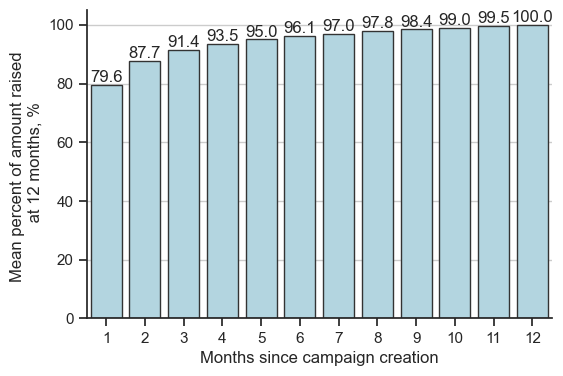

In [161]:
sns.set(style="ticks")
plt.figure(figsize=(6, 4))

ax = sns.barplot(data=don_merge_gb, 
              x='time_delta_months_whole', 
              y='per_cum',
            capsize=0.2, errwidth=1.5,
            errcolor=".2", edgecolor=".2",
            color='lightblue', saturation=0.8,
                 errorbar=None
          )
#errorbar='sd'

ax.set_ylabel('Mean percent of amount raised \n at 12 months, %')
ax.set_xlabel('Months since campaign creation')
ax.yaxis.grid(True)

ax.bar_label(ax.containers[0], fontsize=12, fmt='%.1f')

sns.despine()

plt.show()

# plt.savefig("../plots/donations.pdf", bbox_inches='tight')

In [162]:
don_merge_gb.groupby('time_delta_months_whole')['per_cum'].agg([np.mean, np.std])

,mean,std
time_delta_months_whole,,
1,79.637517,27.005133
2,87.713581,22.382399
3,91.443139,19.212313
4,93.530731,16.963283
5,95.025092,14.965028
6,96.140931,13.222232
7,97.043168,11.607085
8,97.790030,9.942755
9,98.418886,8.359191
